# NLP实战项目 -- 基于自然语言处理的搜索引擎公司用户画像

## 数据读取

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import jieba
import numpy as np
import seaborn as sns
import tqdm

In [3]:
train = pd.read_csv("./data/train.csv", sep="###__###",header = None,encoding="utf-8")
test = pd.read_csv("./data/test.csv", sep="###__###",header = None,encoding="utf-8")

### 数据的列名 

In [15]:
train.columns = ['ID', 'Age', 'Gender', 'Education', 'Query_List']
test.columns = ["ID","Query_List"]

In [16]:
print("train维度:",train.shape,"\ntest维度:",test.shape)

train维度: (100000, 5) 
test维度: (100000, 2)


In [17]:
print("train的数据结构:\n",train.head())
print("#"*60)
print("test的数据结构:\n",test.head())

train的数据结构:
                                  ID  Age  Gender  Education  \
0  22DD920316420BE2DF8D6EE651BA174B    1       1          4   
1  43CC3AF5A8D6430A3B572337A889AFE4    2       1          3   
2  E97654BFF5570E2CCD433EA6128EAC19    4       1          0   
3  6931EFC26D229CCFCEA125D3F3C21E57    4       2          3   
4  E780470C3BB0D340334BD08CDCC3C71A    2       2          4   

                                          Query_List  
0  柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...  
1  广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...  
2  钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...  
3  最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...  
4  干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...  
############################################################
test的数据结构:
                                  ID  \
0  ED89D43B9F602F96D96C25255F7C228C   
1  83C3B7B4AAF8074655A8079F561A76D6   
2  CA9F675A024FB2353849350A35CF8B0F   
3  DE45B5C4E57AAEBCF3FDFA2A774093BF   
4  406A681

## 数据预处理

上面已经对文本进行了**分词**以及**去停用词**处理，这是在做`NLP`的必要的数据处理，然而，对于本任务来说，**空格**、**停用词**中包含的信息可能还不小，比如，高学历的人在查询时更大的可能会敲如逗号、空格，而文化程度低的人，可能会输入一大串，那么如何进行数据预处理呢？

1. 信息粒度

- 可以有不同的信息粒度：字、词、短语(n-gram)
- 另外分词工具库也可以用jieba以外的工具，比如THULC和NLPIR等等

2. 人工特征提示

除去本身文本的信息，还有一些人工特征，也会有作用，大家可以考虑加入的形态。比如：

  - 查询query个数
  - 查询query的平均长度
  - 查询query的最大长度
  - 有空格的query占总查询的比例
  - 英文查询词的比例
  - ...

3. 其他特征

- 年龄在19岁至23岁区间的自然人会有较多的搜索行为与大学生活、社交等主题有关
- 男性相比女性会在军事、汽车等主题有更多的搜索行为
- 高学历人群会更加倾向于获取社会、经济等主题的信息

### 年龄类的数据预处理

和年龄相关的信息，我们能想到的有:
- 关注点（词汇主题）：比如年轻人关注的是明星、歌星、歌曲之类的信息，中老年人呢，关注的可能更多的是养生，生孩子（男女都考虑，到了那个年纪，谁都关注）；【所以，是否可以使用主题模型呢，或者说，统计词频截取一定词频以上的词】
- 搜索信息量：年轻人可能搜索更多一点，老年人搜索更少一点；【这是否需要另外进行判别呢】
- 19-23岁的人更多的关注的校园生活，更大岁数的人更多的关注投资

### 性别类标签

性别类数据
和性别相关的信息，如：
- 关注点：男生更关注军事、汽车等主题信息，女生或更多的在化妆、美容\n",

### 教育水平标签

和教育时评相关的信息，如：
- 输入信息的标准程度，有无空格、逗号\n",
- 查询信息里面的英文占比\n",
- 单条查询长度\n",
- 查询个数\n",
- 里面的网站、邮箱占比（基本上一个网址或者一个邮箱就是一条搜索记录）

### 进一步的策略

首先，我们可以对数据进行分析，比如，就和参考资料中给定的那样，
- 每个ID的总的查询数目与各个标签之间的关系；
- 每个ID查询中所有查询的平均长度与各个类别之间的关系；
- 每个ID的最大查询长度与各个类别之间的关系；
- 存在空格、逗号的查询占总查询的比例与各个类别之间的关系；
- 存在英语词汇的查询个数占总个数的比例与各个类别之间的关系
- 存在网址、邮箱的查询占总查询的比例与各个类别之间的关系

其次，我们可以搞一个正演，取各个类别对应的词汇出现频率的前1000个诸位主题词汇

### 文本数据中信息的提取

In [26]:
# 提取每个ID的总的查询数目
train.loc[:,"Query_Sum_num"] = train.loc[:,"Query_List"].transform(lambda x: len(x.split("\t")))
train.loc[:,"avg_query_len"] = train.loc[:,"Query_List"].transform(lambda x: np.mean([len(i) for i in x.split("\t")]))
train.loc[:,"max_query_len"] = train.loc[:,"Query_List"].transform(lambda x: np.max([len(i) for i in x.split("\t")]))
train.loc[:,"exist_space_or_comma_query_rate"] = train.loc[:,"Query_List"].transform(lambda x: np.sum([1 for i in x.split("\t") if " " in list(i) or "," in list(i)])/len(x.split("\t")))
train.loc[:,"exist_english_query_rate"] = train.loc[:,"Query_List"].transform(lambda x: np.sum([1 for i in x.split("\t")  if re.search("[A-Za-z]+",i)])/len(x.split("\t")))
train.loc[:,"exist_web_mail_query_rate"] = train.loc[:,"Query_List"].transform(lambda x: np.sum([1 for i in x.split("\t")  if re.search("|".join(["http[a-z1-9:.]+","[a-zA-Z1-9]+@[a-zA-Z1-9.]+"]),i)])/len(x.split("\t")))

In [28]:
print(train.head())

                                 ID  Age  Gender  Education  \
0  22DD920316420BE2DF8D6EE651BA174B    1       1          4   
1  43CC3AF5A8D6430A3B572337A889AFE4    2       1          3   
2  E97654BFF5570E2CCD433EA6128EAC19    4       1          0   
3  6931EFC26D229CCFCEA125D3F3C21E57    4       2          3   
4  E780470C3BB0D340334BD08CDCC3C71A    2       2          4   

                                          Query_List  Query_Sum_num  \
0  柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...            275   
1  广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...            186   
2  钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...            104   
3  最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...            173   
4  干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...            117   

   avg_query_len  max_query_len  exist_space_or_comma_query_rate  \
0       8.654545             40                         0.036364   
1       8.838710             28                         0.

### 各个信息与标签之间的关系

In [35]:
print("train的列名：",train.columns)

train的列名： Index(['ID', 'Age', 'Gender', 'Education', 'Query_List', 'Query_Sum_num',
       'avg_query_len', 'max_query_len', 'exist_space_or_comma_query_rate',
       'exist_english_query_rate', 'exist_web_mail_query_rate'],
      dtype='object')


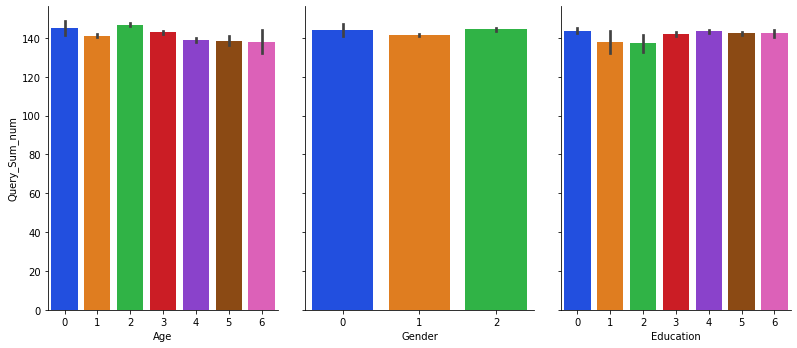

In [34]:
# Query_Sum_num与各个标签之间的关系
g = sns.PairGrid(train,
                 x_vars=["Age", "Gender", "Education"],
                 y_vars=["Query_Sum_num"],
                 aspect=.75, size=5)
g.map(sns.barplot, palette="bright")

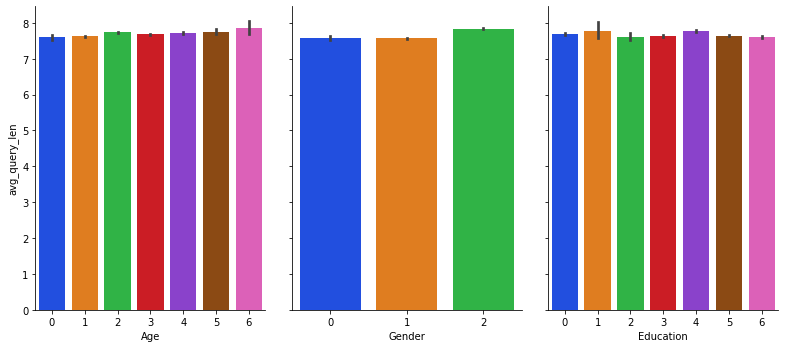

In [36]:
# avg_query_len与各个标签之间的关系
g = sns.PairGrid(train,
                 x_vars=["Age", "Gender", "Education"],
                 y_vars=["avg_query_len"],
                 aspect=.75, size=5)
g.map(sns.barplot, palette="bright")

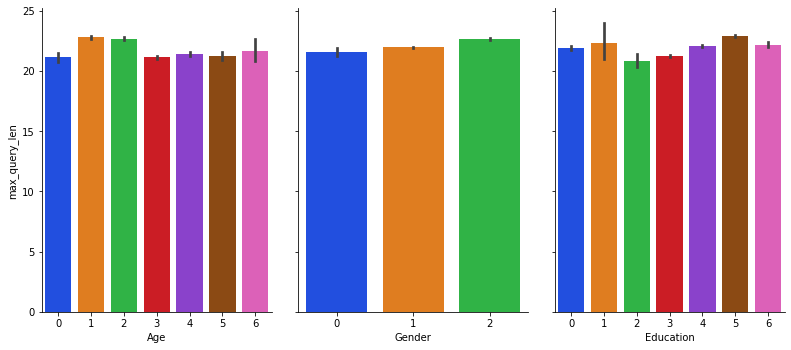

In [37]:
# max_query_len与各个标签之间的关系
g = sns.PairGrid(train,
                 x_vars=["Age", "Gender", "Education"],
                 y_vars=["max_query_len"],
                 aspect=.75, size=5)
g.map(sns.barplot, palette="bright")

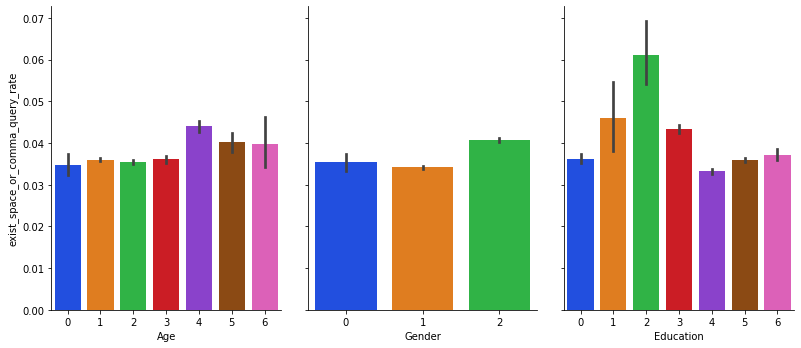

In [38]:
# exist_space_or_comma_query_rate与各个标签之间的关系
g = sns.PairGrid(train,
                 x_vars=["Age", "Gender", "Education"],
                 y_vars=["exist_space_or_comma_query_rate"],
                 aspect=.75, size=5)
g.map(sns.barplot, palette="bright")

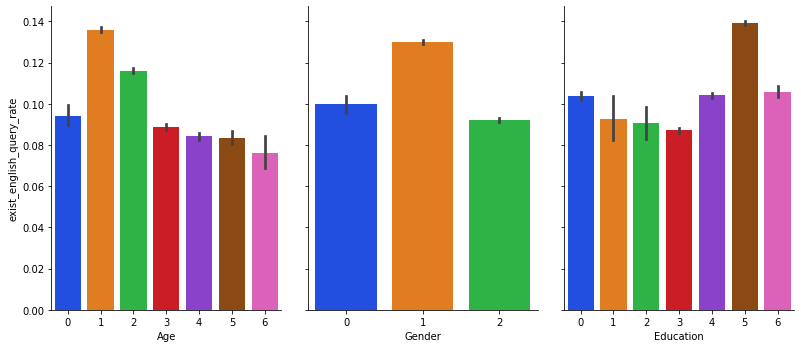

In [39]:
# exist_english_query_rate与各个标签之间的关系
g = sns.PairGrid(train,
                 x_vars=["Age", "Gender", "Education"],
                 y_vars=["exist_english_query_rate"],
                 aspect=.75, size=5)
g.map(sns.barplot, palette="bright")

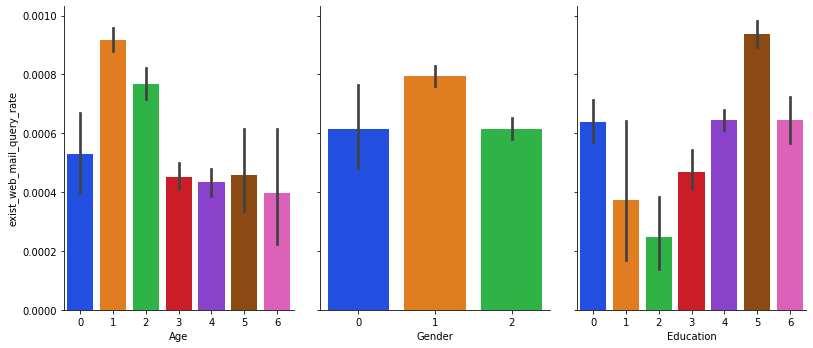

In [40]:
# exist_web_mail_query_rate与各个标签之间的关系
g = sns.PairGrid(train,
                 x_vars=["Age", "Gender", "Education"],
                 y_vars=["exist_web_mail_query_rate"],
                 aspect=.75, size=5)
g.map(sns.barplot, palette="bright")

###  读取停用词

In [23]:
# 读取停用词
stopwords = pd.read_csv("./data/stopwords/cn_stopwords.txt",names=["stopwords"],sep="\t",encoding="utf-8")
stopwords = stopwords["stopwords"].values.tolist()

In [24]:
stopwords[50:60]

['不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不独', '不管', '不至于']

### 数据中提取高频词汇

In [57]:
train.loc[:,"count_word"] = train.loc[:0,"Query_List"].transform(lambda x: re.sub("|".join(["(?<=\t)[:]*http\S+(?=\t)","(?<=\t)[A-Za-z0-9]+@[A-Za-z0-9.]+(?=\t)","(?<=\t)ｗｗｗ\S+(?=\t)","(?<=\t)www\S+(?=\t)","(?<=\t)[0-9]{6,}(?=\t)"]),"",x))\
                            .transform(lambda x : [i for i in jieba.lcut(x) if len(i)>1])\
                            .transform(lambda x : " ".join([i for i in x if i not in stopwords])).values
train.head()

,ID,Age,Gender,Education,Query_List,Query_Sum_num,avg_query_len,max_query_len,exist_space_or_comma_query_rate,exist_english_query_rate,exist_web_mail_query_rate,count_word
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,8.654545,40,0.036364,0.105455,0.058182,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,8.838710,28,0.091398,0.053763,0.000000,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,5.740385,21,0.019231,0.125000,0.000000,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,6.502890,20,0.028902,0.034682,0.000000,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,8.649573,20,0.059829,0.119658,0.000000,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...


### 由于上述步骤计算缓慢，在这儿，我们将数据进行保存

In [58]:
import os
new_data_path = "./new_data/"
if not os.path.exists(new_data_path):
    os.system("mkdir {}".format(new_data_path))
train.to_csv(new_data_path+"train_new.txt")

### 构建训练数据

In [59]:
train_df = pd.read_csv("./new_data/train_new.txt")

In [60]:
train_df.head()

,Unnamed: 0,ID,Age,Gender,Education,Query_List,Query_Sum_num,avg_query_len,max_query_len,exist_space_or_comma_query_rate,exist_english_query_rate,exist_web_mail_query_rate,count_word
0,0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,8.654545,40,0.036364,0.105455,0.058182,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
1,1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,8.838710,28,0.091398,0.053763,0.000000,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
2,2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,5.740385,21,0.019231,0.125000,0.000000,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
3,3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,6.502890,20,0.028902,0.034682,0.000000,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
4,4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,8.649573,20,0.059829,0.119658,0.000000,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...


In [66]:
train_array = train_df.loc[:,["count_word","Age","Gender","Education"]].values

In [101]:
train_x_y = list(map(lambda x: (x[0],[x[1],x[2],x[3]]),train_array))

In [102]:
import random
random.shuffle(train_x_y)

### 训练集测试集的切分

In [103]:
from sklearn.model_selection import train_test_split
x,label = zip(*train_x_y)
x_train, x_test, y_train, y_test = train_test_split(x,label,test_size=0.33)

In [108]:
train_label = np.array(y_train)
test_label = np.array(y_test)
age_label_train,gender_label_train,education_label_train = train_label[:,0],train_label[:,1],train_label[:,2]
age_label_test,gender_label_test,education_label_test = test_label[:,0],test_label[:,1],test_label[:,2]

## 特征提取

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(analyzer='word', # tokenise by character ngram
                        ngram_range=(1,4),  # use ngrams of size 1, 2, 3, 4\
                        max_features=20000,  # keep the most common 2000 ngrams
                        )

In [110]:
vec.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

## 模型构建

### 朴素贝叶斯

#### 年龄(准确率：0.39)

In [95]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(vec.transform(x_train), age_label_train)
classifier.score(vec.transform(x_test), age_label_test)

0.39081818181818184

#### 性别（准确率：0.57）

In [96]:
classifier.fit(vec.transform(x_train), gender_label_train)
classifier.score(vec.transform(x_test), gender_label_test)

0.5668484848484848

#### 教育程度（准确率：0.37）

In [97]:
classifier.fit(vec.transform(x_train), education_label_train)
classifier.score(vec.transform(x_test), education_label_test)

0.37372727272727274

### 交叉验证

#### 年龄（准确率：0.0056）

In [105]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score

vec.fit(x)

def stratifiedkfold_cv(x, y, clf_class, shuffle=True, n_folds=5, **kwargs):
    stratifiedk_fold = StratifiedKFold(n_splits=n_folds, shuffle=shuffle)
    y_pred = y[:]
    for train_index, test_index in stratifiedk_fold.split(x, y):
        X_train, X_test = x[train_index], x[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred 

NB = MultinomialNB
print(precision_score(np.array(label)[:,0], stratifiedkfold_cv(vec.transform(x),np.array(label)[:,0],NB), average='macro'))

0.05570857142857143


#### 性别（准确率：0.18992）

In [106]:
print(precision_score(np.array(label)[:,1], stratifiedkfold_cv(vec.transform(x),np.array(label)[:,1],NB), average='macro'))

0.18992


#### 教育程度（准确率：0.05301）

In [107]:
print(precision_score(np.array(label)[:,2], stratifiedkfold_cv(vec.transform(x),np.array(label)[:,2],NB), average='macro'))

0.05301


### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(vec.transform(x_train), age_label_train)
svm.score(vec.transform(x_test), age_label_test)

根据现有的结果，机器学习做能做的就是，就是对结果分词，之后进行预测；然而，对于网址信息、邮箱信息、空格等信息的加入需要进一步考虑，对于他们，是否直接放进去就可以了呢？

预知后事如何，窃听